<a href="https://colab.research.google.com/github/Sreerag-ibtl/dumb-sign-classifier/blob/master/dumb_sign_classification_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Upload kaggle.json

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sreeragibtl","key":"68694380e87480bd05a5204966fcef16"}'}

# Download dataset.

In [ ]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle
#!kaggle datasets download -d ahmedkhanak1995/sign-language-gesture-images-dataset
!kaggle datasets download -d grassknoted/asl-alphabet

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory
100% 1.02G/1.03G [00:19<00:00, 36.1MB/s]
100% 1.03G/1.03G [00:19<00:00, 55.3MB/s]


In [ ]:
#!unzip sign-language-gesture-images-dataset.zip
!unzip asl-alphabet.zip

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing191.jpg  
  inflating: asl_alphabet_t

# Importing libraries.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, BatchNormalization, Dropout,
                                     Dense, AveragePooling2D,Flatten)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

import matplotlib.pyplot as plt

import shutil
import os

# Create test set.

In [ ]:
def create_test_set(path,count=20):
  test_parent="test"
  try:
    os.mkdir("test")
  except FileExistsError:
    shutil.rmtree(test_parent,ignore_errors=True)
    os.mkdir("test")
  for subdir in os.listdir(path):
    files_in_subdir_20=os.listdir(os.path.join(path,subdir))[:20]
    os.mkdir(os.path.join(test_parent,subdir))
    for filename in files_in_subdir_20:
      #print(os.path.join(test_parent,subdir,filename))
      os.rename(os.path.join(path,subdir,filename),os.path.join(test_parent,subdir,filename))

In [ ]:
create_test_set("/content/Gesture Image Data")

# Build the augmentation pipeline

In [ ]:
aug = ImageDataGenerator( validation_split=0.3, rescale=1/255.0, rotation_range=10 )
#Augmenting images to enhanse the num
train_gen = aug.flow_from_directory("/content/asl_alphabet_train/asl_alphabet_train", 
                                    class_mode="sparse",subset="training",target_size=(256,256))
val_gen   = aug.flow_from_directory("/content/asl_alphabet_train/asl_alphabet_train", 
                                    class_mode="sparse",subset="validation",target_size=(256,256))
#test_gen  = aug.flow_from_directory("/content/test",
#                                    class_mode="sparse",target_size=(256,256))

Found 60900 images belonging to 29 classes.
Found 26100 images belonging to 29 classes.


# Print the class indices.

In [ ]:
train_gen.class_indices

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25,
 'del': 26,
 'nothing': 27,
 'space': 28}

# Visualising the data.

7.0


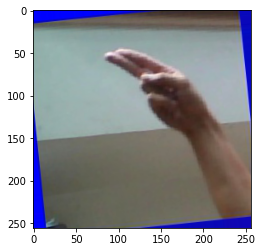

In [ ]:
image, label=train_gen.next()
plt.imshow( image[0] );
print( label[0] )

# Transfer learning.

Load mobilenet as base model.

In [ ]:
basemodel = MobileNetV2( weights="imagenet", include_top=False, input_shape=(256,256,3) )

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 1s 0us/step


Set n layers non trainable.

In [ ]:
for layer in basemodel.layers[:100]:
  layer.trainable=False

In [ ]:
def createModel(basemodel):
  x=basemodel.output
  x=Flatten()(x)
  x=Dense(128,activation="relu")(x)
  x=Dense(29,activation="softmax")(x)
  model=Model(inputs=basemodel.input, outputs=x)
  return model

In [ ]:
model=createModel(basemodel)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 257, 257, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

# Custom model.

In [ ]:
model=Sequential()
model.add(Conv2D(64,(3,3), activation="relu",input_shape=(256,256,3)))
model.add(AveragePooling2D((3,3)))
model.add(BatchNormalization())
model.add(Conv2D(32,(2,2),activation="relu"))
model.add(AveragePooling2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(16,(2,2),activation="relu"))
model.add(AveragePooling2D((2,2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(37,activation="softmax"))

# Create directory to store the model.

In [ ]:
!mkdir models

# Define callbacks.

In [ ]:
callback1=EarlyStopping(patience=1)
callback2=ModelCheckpoint(
    "models/weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor='val_loss', verbose=0, save_best_only=False,
    save_weights_only=False, mode='auto', save_freq='epoch')

# Compile and train the model.

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [ ]:
history=model.fit_generator(train_gen,epochs=5,validation_data=val_gen,callbacks=[callback2])

Epoch 1/5
1904/1904 [==============================] - 1189s 625ms/step - loss: 0.4230 - acc: 0.8941 - val_loss: 3.3333 - val_acc: 0.5743
Epoch 2/5
1904/1904 [==============================] - 1155s 607ms/step - loss: 0.0811 - acc: 0.9806 - val_loss: 10.1644 - val_acc: 0.3644
Epoch 3/5
1904/1904 [==============================] - 1152s 605ms/step - loss: 0.0559 - acc: 0.9868 - val_loss: 2.8935 - val_acc: 0.6302
Epoch 4/5
1904/1904 [==============================] - 1169s 614ms/step - loss: 0.0704 - acc: 0.9862 - val_loss: 3.2077 - val_acc: 0.7488
Epoch 5/5
1904/1904 [==============================] - 1175s 617ms/step - loss: 0.0273 - acc: 0.9939 - val_loss: 1.4940 - val_acc: 0.8236


In [ ]:
!cp "/content/models/weights.05-1.49.hdf5" "/content/drive/My Drive/rapid_projects/dumb_sign"

# Predict using the saved model.

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
loaded_model=load_model("/content/drive/My Drive/rapid_projects/dumb_sign/weights.05-1.49.hdf5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
import cv2
import numpy as np
image=cv2.imread("/content/B_0.jpg")
image=cv2.resize(image,(256,256))
image=image/255.
image=np.expand_dims(image,0)
preds=loaded_model.predict(image)[0]
np.argmax(preds)

1